In [1]:
import sys
sys.path.append('..')
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import xarray as xr
import random as rd
import platform
%matplotlib inline

from tool.train_evaluate import Trainer, Evaluator
from tool.dataset import NetCDFDataset
from tool.utils import Util

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch import optim

Load specific variables for each dataset

In [3]:
%run dataset-variables.py

version = 1
dataset = ../data/dataset-chirps-1981-2019-seq5-ystep5.nc
input_size = 50
step = 5
dropout rate = 0.2
learning rate = 0.001
param = {'encoder_layer_size': 2, 'decoder_layer_size': 2, 'kernel_size': 3, 'filter_size': 64}


In [4]:
util = Util('STConvS2S', version=version, dataset=dataset)

os.environ["CUDA_VISIBLE_DEVICES"]='0'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

Seed

In [5]:
seed = 1000
np.random.seed(seed)
rd.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic=True

In [6]:
def init_seed(seed):
    np.random.seed(seed)

Hyperparameters

In [7]:
epochs = 50
batch_size = 50
validation_split = 0.2
test_split = 0.2
encoder_layer_size = param['encoder_layer_size']
decoder_layer_size = param['decoder_layer_size']
kernel_size = param['kernel_size']
filter_size = param['filter_size']

Loading the dataset

In [8]:
ds = xr.open_mfdataset(dataset_file)
#ds = ds[dict(sample=slice(0,500))]

In [9]:
train_dataset = NetCDFDataset(ds, test_split=test_split, validation_split=validation_split)
val_dataset = NetCDFDataset(ds, test_split=test_split, validation_split=validation_split, is_validation=True)
test_dataset = NetCDFDataset(ds, test_split=test_split, validation_split=validation_split, is_test=True)

In [10]:
print('[X_train] Shape:', train_dataset.X.shape)
print('[y_train] Shape:', train_dataset.y.shape)
print('[X_val] Shape:', val_dataset.X.shape)
print('[y_val] Shape:', val_dataset.y.shape)
print('[X_test] Shape:', test_dataset.X.shape)
print('[y_test] Shape:', test_dataset.y.shape)

[X_train] Shape: torch.Size([8376, 1, 5, 50, 50])
[y_train] Shape: torch.Size([8376, 1, 5, 50, 50])
[X_val] Shape: torch.Size([2792, 1, 5, 50, 50])
[y_val] Shape: torch.Size([2792, 1, 5, 50, 50])
[X_test] Shape: torch.Size([2792, 1, 5, 50, 50])
[y_test] Shape: torch.Size([2792, 1, 5, 50, 50])


In [11]:
params = {'batch_size': batch_size,
          'num_workers': 4, 
          'worker_init_fn': init_seed}

train_loader = DataLoader(dataset=train_dataset, shuffle=True, **params)
val_loader = DataLoader(dataset=val_dataset, shuffle=False, **params)
test_loader = DataLoader(dataset=test_dataset, shuffle=False, **params)

Creating the model

In [12]:
class EncoderSTCNN(nn.Module):
    
    def __init__(self, layer_size, kernel_size, initial_filter_size, channels):
        super(EncoderSTCNN, self).__init__()
        self.padding = kernel_size // 2
        self.conv_layers = nn.ModuleList()
        self.relu_layers = nn.ModuleList()
        self.batch_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()
        
        spatial_kernel_size =  [1, kernel_size, kernel_size]
        spatial_padding =  [0, self.padding, self.padding]
        
        out_channels = initial_filter_size
        in_channels = channels
        for i in range(layer_size):
            self.conv_layers.append(
                nn.Conv3d(in_channels=in_channels, out_channels=out_channels, 
                          kernel_size=spatial_kernel_size, padding=spatial_padding, bias=False)
            )
            self.relu_layers.append(nn.ReLU())
            self.batch_layers.append(nn.BatchNorm3d(out_channels))
            self.dropout_layers.append(nn.Dropout(dropout_rate))
            in_channels = out_channels
        
    def forward(self, x):
        for conv, relu, batch, drop in zip(self.conv_layers, self.relu_layers, 
                                           self.batch_layers, self.dropout_layers):
            x = conv(x)
            x = batch(x)
            x = relu(x)
            x = drop(x)
            
        return x

In [13]:
class DecoderSTCNN(nn.Module):
    
    def __init__(self, layer_size, kernel_size, initial_filter_size, channels):
        super(DecoderSTCNN, self).__init__()
        self.padding = kernel_size - 1
        self.conv_layers = nn.ModuleList()
        self.relu_layers = nn.ModuleList()
        self.batch_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()

        temporal_kernel_size =  [kernel_size, 1, 1]
        temporal_padding =  [self.padding, 0, 0]
        
        out_channels = initial_filter_size
        in_channels = channels
        for i in range(layer_size):
            self.conv_layers.append(
                nn.Conv3d(in_channels=in_channels, out_channels=out_channels, 
                          kernel_size=temporal_kernel_size, padding=temporal_padding, bias=False)
            )
            self.relu_layers.append(nn.ReLU())
            self.batch_layers.append(nn.BatchNorm3d(out_channels))
            self.dropout_layers.append(nn.Dropout(dropout_rate))
            in_channels = out_channels

        padding_final = [kernel_size // 2, 0, 0]
        self.conv_final = nn.Conv3d(in_channels=in_channels, out_channels=1, 
              kernel_size=temporal_kernel_size, padding=padding_final, bias=True)
        
    def forward(self, x):
        for conv, relu, batch, drop in zip(self.conv_layers, self.relu_layers, 
                                           self.batch_layers, self.dropout_layers):
            x = conv(x)[:,:,:-self.padding,:,:]
            x = batch(x)
            x = relu(x)
            x = drop(x)
            
        out = self.conv_final(x)
        return out

In [14]:
class STConvS2S(nn.Module):
    
    def __init__(self, encoder_layer_size, decoder_layer_size, kernel_size, 
                 filter_size, channels):
        super(STConvS2S, self).__init__()
        
        self.encoder = EncoderSTCNN(layer_size=encoder_layer_size, kernel_size=kernel_size, 
                                  initial_filter_size=filter_size, channels=channels)
        self.decoder = DecoderSTCNN(layer_size=decoder_layer_size, kernel_size=kernel_size, 
                                  initial_filter_size=filter_size, channels=filter_size)
        
    def forward(self, x):
        out = self.encoder(x)
        return self.decoder(out)

In [15]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [16]:
model = STConvS2S(encoder_layer_size, decoder_layer_size, kernel_size, 
                 filter_size, channels=train_dataset.X.shape[1]).to(device)
criterion = RMSELoss()

opt_params = {'lr': lr, 
              'alpha': 0.9, 
              'eps': 1e-6}

optimizer = torch.optim.RMSprop(model.parameters(), **opt_params)

Training the model

In [17]:
%%time
checkpoint_filename = util.get_checkpoint_filename()

print('Train on {} samples, validate on {} samples'.format(len(train_dataset), len(val_dataset)))

trainer = Trainer(model, criterion, optimizer, train_loader, val_loader, epochs, 
                          device, verbose=True, patience=None, no_stop=True)

train_losses, val_losses = trainer.fit(checkpoint_filename)

Train on 8376 samples, validate on 2792 samples
Epoch: 1/50 - loss: 6.5579 - val_loss: 6.4933
=> Saving a new best
Epoch: 2/50 - loss: 6.4694 - val_loss: 6.4900
=> Saving a new best
Epoch: 3/50 - loss: 6.4633 - val_loss: 6.4914
Epoch: 4/50 - loss: 6.4578 - val_loss: 6.4755
=> Saving a new best
Epoch: 5/50 - loss: 6.4550 - val_loss: 6.4746
=> Saving a new best
Epoch: 6/50 - loss: 6.4520 - val_loss: 6.4834
Epoch: 7/50 - loss: 6.4486 - val_loss: 6.4678
=> Saving a new best
Epoch: 8/50 - loss: 6.4469 - val_loss: 6.4661
=> Saving a new best
Epoch: 9/50 - loss: 6.4457 - val_loss: 6.4696
Epoch: 10/50 - loss: 6.4441 - val_loss: 6.4722
Epoch: 11/50 - loss: 6.4430 - val_loss: 6.4615
=> Saving a new best
Epoch: 12/50 - loss: 6.4409 - val_loss: 6.4852
Epoch: 13/50 - loss: 6.4406 - val_loss: 6.4646
Epoch: 14/50 - loss: 6.4372 - val_loss: 6.4816
Epoch: 15/50 - loss: 6.4380 - val_loss: 6.4550
=> Saving a new best
Epoch: 16/50 - loss: 6.4364 - val_loss: 6.4739
Epoch: 17/50 - loss: 6.4360 - val_loss: 6

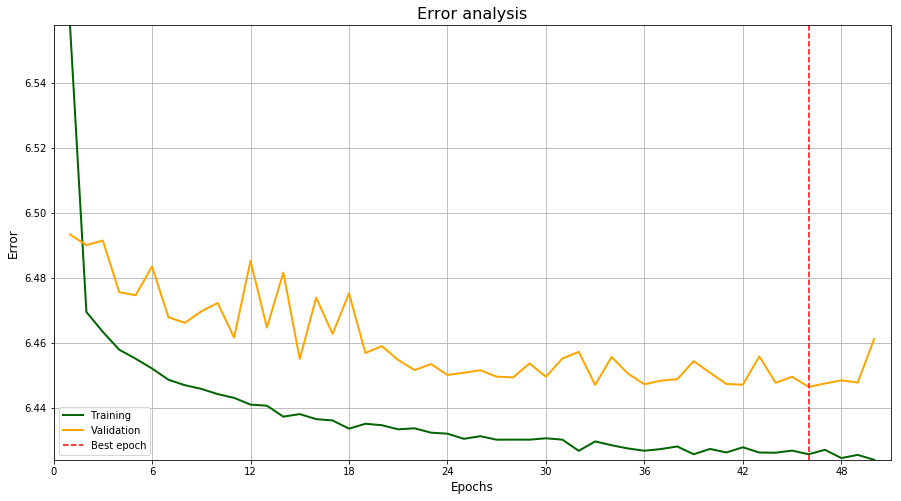

In [18]:
util.save_loss(train_losses, val_losses)
util.plot([train_losses, val_losses], ['Training', 'Validation'], 
          'Epochs', 'Error', 'Error analysis', inline=True)

In [19]:
model,_, best_epoch, val_loss = trainer.load_checkpoint(checkpoint_filename)

=> Loaded checkpoint chirps_1_20190928-001216.pth.tar (best epoch: 46, validation error: 6.4464)


Evaluating the model

In [20]:
evaluator = Evaluator(model, criterion, test_loader, device)
test_loss = evaluator.eval()
loss_type = type(criterion).__name__
print(f'STConvS2S {loss_type}: {test_loss:.4f}')

STConvS2S RMSELoss: 6.4067


In [21]:
if (torch.cuda.is_available()):
    torch.cuda.empty_cache()

Notification via email

In [23]:
model_info = {'Jupyter': 'yes',
              'best_epoch': best_epoch,
              'val_error': val_loss,
              'test_error': test_loss,
              'loss_type': loss_type,
              'step': step,
              'e_layer': encoder_layer_size,
              'e_kernel_size': kernel_size,
              'e_filter': filter_size,
              'd_layer': decoder_layer_size,
              'd_kernel_size': kernel_size,
              'd_filter': filter_size,
              'dropout_rate': dropout_rate,
              'dataset': dataset,
              'hostname': platform.node()}

In [24]:
util.send_email(model_info)

2153.3084013462067
email sent
